# ChebNet

In [42]:
import ChebNet
import CORA
import utils

import dgl
import torch

In [43]:
# Reload when files are changed
import importlib
importlib.reload(ChebNet)
importlib.reload(CORA)
importlib.reload(utils)

<module 'utils' from '/Users/alice/Documents/GIT/CayleyNets/utils.py'>

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [29]:
# Checking torch and device

# Torch version
print(torch.__version__)

# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

2.1.1
True
True


In [30]:
# Import dataset
cora = CORA.CORA()

Parsing files...
Done.


In [31]:
# Use GPU if available (DGL doesn't seem to support MPS)
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
train_mask, test_mask, val_mask = utils.split_train_test_val(cora.n, 500, 500) # extended split of the CORA dataset

In [33]:
# Hyperparameters (Section 4.5)
in_feats = cora.n_features
n_classes = cora.n_classes
n_hidden = 16
n_layers = 1 # number of hidden+output layers
k = 10 # Chebyshev polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper, only that it is 2r, r being the degree of the Cayley polynomial

In [34]:
# Graph as an object
graph = dgl.from_scipy(cora.adjacency)

# Features and labels as tensors
features = torch.Tensor(cora.features).to(device)
labels = torch.Tensor(cora.labels).long().to(device)

# Masks as tensors
train_mask = torch.Tensor(train_mask).bool().to(device)
test_mask = torch.Tensor(test_mask).bool().to(device)
val_mask = torch.Tensor(val_mask).bool().to(device)

In [35]:
# Define model
p = 0.6 # dropout probability
model = ChebNet.ChebNet(in_feats, n_classes, n_hidden, n_layers, k, p).to(device)
model

ChebNet(
  (layers): ModuleList(
    (0): ChebConv(
      (linear): Linear(in_features=14330, out_features=16, bias=True)
    )
    (1): ChebConv(
      (linear): Linear(in_features=160, out_features=7, bias=True)
    )
  )
)

In [36]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')

Number of parameters: 230423
Number of parameters: 229296
Number of parameters: 1127


In [37]:
# Optimizer
lr = 5e-3
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [38]:
# Train the model
batch_size = 32
epochs = 200

# save loss values for plotting
loss_values = []
val_score = []
train_score = []

verbose = True
for e in range(epochs):
    # Compute output
    output = model(graph, features)

    # Compute loss
    logp = F.log_softmax(output, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss_values.append(loss.item())

    # Perform backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    score = utils.eval_model(model, graph, features, labels, train_mask)
    train_score.append(score)

    score = utils.eval_model(model, graph, features, labels, val_mask)
    val_score.append(score)

    if verbose and e % 10 == 0:
        print("Epoch {:02d} | Loss {:.3f} | Accuracy (validation) {:.3f}".format(e, loss.item(), score))

Epoch 00 | Loss 1.944 | Accuracy (validation) 0.290
Epoch 10 | Loss 0.968 | Accuracy (validation) 0.688
Epoch 20 | Loss 0.434 | Accuracy (validation) 0.750
Epoch 30 | Loss 0.315 | Accuracy (validation) 0.746
Epoch 40 | Loss 0.290 | Accuracy (validation) 0.740
Epoch 50 | Loss 0.287 | Accuracy (validation) 0.746
Epoch 60 | Loss 0.290 | Accuracy (validation) 0.746
Epoch 70 | Loss 0.292 | Accuracy (validation) 0.740
Epoch 80 | Loss 0.291 | Accuracy (validation) 0.742
Epoch 90 | Loss 0.289 | Accuracy (validation) 0.748
Epoch 100 | Loss 0.287 | Accuracy (validation) 0.746
Epoch 110 | Loss 0.285 | Accuracy (validation) 0.754
Epoch 120 | Loss 0.284 | Accuracy (validation) 0.758
Epoch 130 | Loss 0.283 | Accuracy (validation) 0.754
Epoch 140 | Loss 0.282 | Accuracy (validation) 0.756
Epoch 150 | Loss 0.282 | Accuracy (validation) 0.756
Epoch 160 | Loss 0.281 | Accuracy (validation) 0.760
Epoch 170 | Loss 0.282 | Accuracy (validation) 0.762
Epoch 180 | Loss 0.281 | Accuracy (validation) 0.762
Epo

In [39]:
test_score = utils.eval_model(model, graph, features, labels, test_mask)
print("Test accuracy {:.3f}".format(test_score))

Test accuracy 0.752


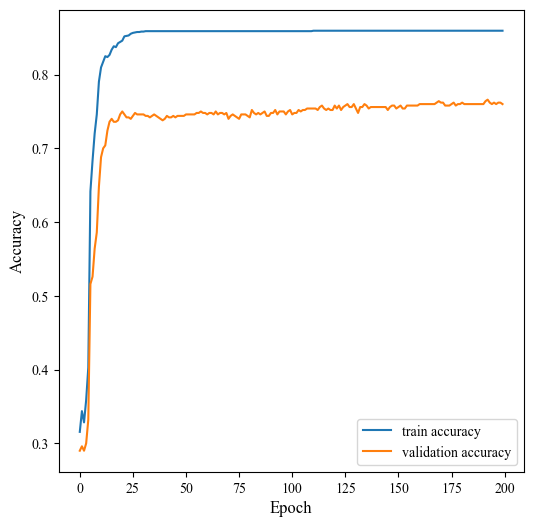

In [40]:
utils.plot_accuracy(train_score, val_score)

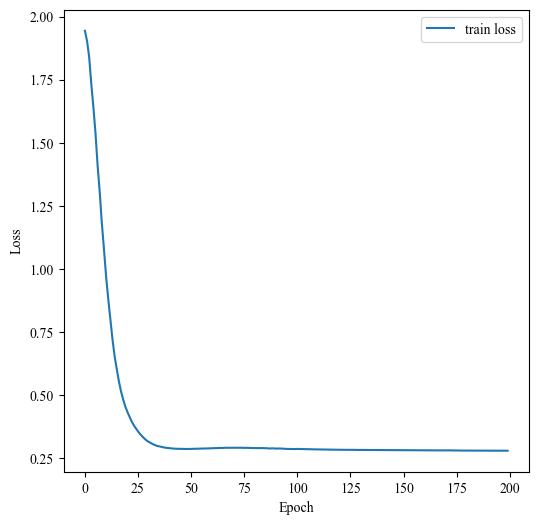

In [44]:
utils.plot_loss(loss_values)